## 四个主流估计器A股深交所的测试

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from sklearn.linear_model import LinearRegression

In [2]:
se = SpreadEstimator()
univ = ~np.isnan(se.data.data_dic['close'])  # 合法的univ

In [3]:
def get_xy(x,y,univ):
    xx = []
    yy = []
    for i in range(len(x)):
        se = (~np.isnan(x[i])) & univ[i] & (~np.isnan(y[i]))
        if np.sum(se) == 0:
            continue
        xx.append(x[i:i+1, se].T)
        yy.append(y[i,se])
    return np.vstack(xx), np.hstack(yy)

#### HL, 2012

In [4]:
print(np.sqrt(2)-1)
print(3-np.sqrt(2)*2)

0.41421356237309515
0.1715728752538097


In [6]:
se.data.spread_dic.keys()

dict_keys(['spread', 'relative_spread', 'vol_wtd_rel_bas', 'vol_wtd_bas'])

In [7]:
lr = LinearRegression()

beta = 'prod{tsmean{powv{minus{logv{high},logv{low}},2},2},2}'

high_1 = 'logv{tsdelay{high,1}}'
low_1 = 'logv{tsdelay{low,1}}'
con_1 = 'condition{gt{logv{low},logv{tsdelay{close,1}}},minus{logv{low},logv{tsdelay{close,1}}},minus{close,close}}'
con_2 = 'condition{lt{logv{high},logv{tsdelay{close,1}}},minus{logv{high},logv{tsdelay{close,1}}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{logv{high},' + con + '}'
low_2 = 'minus{logv{low},' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'



print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('ts_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='vol_wtd_rel_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_rel_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('ts_vol_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='vol_wtd_rel_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_rel_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))

cs_rel_sp
mean corr: -0.1741, positive_corr_ratio: 0.0000, corr_IR: -2.8080
0.0005274021274575184

ts_rel_sp
mean corr: -0.1647, positive_corr_ratio: 0.3353, corr_IR: -0.4054
0.0005274021274575184

cs_vol_rel_sp
mean corr: -0.1588, positive_corr_ratio: 0.0000, corr_IR: -2.5224
0.0005275614618757872

ts_vol_rel_sp
mean corr: -0.0852, positive_corr_ratio: 0.4165, corr_IR: -0.2100
0.0005275614618757872


In [10]:
beta = 'prod{tsmean{powv{minus{high,low},2},2},2}'

high_1 = 'tsdelay{high,1}'
low_1 = 'tsdelay{low,1}'
con_1 = 'condition{gt{low,tsdelay{close,1}},minus{low,tsdelay{close,1}},minus{close,close}}'
con_2 = 'condition{lt{high,tsdelay{close,1}},minus{high,tsdelay{close,1}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{high,' + con + '}'
low_2 = 'minus{low,' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'


print('ts_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='vol_wtd_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_vol_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='vol_wtd_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))

ts_sp
mean corr: 0.4855, positive_corr_ratio: 0.8990, corr_IR: 1.4419
0.017850268346097955

cs_sp
mean corr: 0.7400, positive_corr_ratio: 1.0000, corr_IR: 20.5674
0.017850268346097955

cs_vol_sp
mean corr: 0.7686, positive_corr_ratio: 1.0000, corr_IR: 21.7556
0.017505156124712304

ts_vol_sp
mean corr: 0.5622, positive_corr_ratio: 0.9355, corr_IR: 1.8324
0.017505156124712304


#### Roll, 1999

In [11]:
a = 'tsdelta{logv{close},1}'
b = 'tsdelay{tsdelta{logv{close},1},1}'
fml = 'prod{' + a + ',' + b +'}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'


print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('ts_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='vol_wtd_rel_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_rel_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('ts_vol_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='vol_wtd_rel_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_rel_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))


cs_rel_sp
mean corr: -0.2312, positive_corr_ratio: 0.0360, corr_IR: -3.0247
0.0005314135600429788

ts_rel_sp
mean corr: -0.1263, positive_corr_ratio: 0.3559, corr_IR: -0.3411
0.0005314135600429788

cs_vol_rel_sp
mean corr: -0.2129, positive_corr_ratio: 0.0495, corr_IR: -2.6078
0.0005314253388228314

ts_vol_rel_sp
mean corr: -0.0443, positive_corr_ratio: 0.4406, corr_IR: -0.1193
0.0005314253388228314


In [12]:
a = 'tsdelta{close,1}'
b = 'tsdelay{tsdelta{close,1},1}'
fml = 'prod{' + a + ',' + b +'}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('cs_vol_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='vol_wtd_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_vol_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='vol_wtd_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))

cs_sp
mean corr: 0.7924, positive_corr_ratio: 1.0000, corr_IR: 18.7505
0.016293619291864184

ts_sp


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


mean corr: 0.4327, positive_corr_ratio: 0.8657, corr_IR: 1.2250
0.016293619291864184

cs_vol_sp
mean corr: 0.8213, positive_corr_ratio: 1.0000, corr_IR: 21.1992
0.015708381698959887

ts_vol_sp
mean corr: 0.5197, positive_corr_ratio: 0.9225, corr_IR: 1.6242
0.015708381698959887


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


#### CHL

In [14]:
a = 'minus{logv{tsdelay{close,1}},div{add{logv{tsdelay{high,1}},logv{tsdelay{low,1}}},2}}'
b = 'minus{logv{tsdelay{close,1}},div{add{logv{high},logv{low}},2}}'
fml = 'prod{' + a + ',' + b +'}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('ts_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='vol_wtd_rel_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_rel_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('ts_vol_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='vol_wtd_rel_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_rel_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))


cs_rel_sp
mean corr: -0.2317, positive_corr_ratio: 0.0000, corr_IR: -3.9265
0.0005261585578705452

ts_rel_sp
mean corr: -0.1452, positive_corr_ratio: 0.3410, corr_IR: -0.3764
0.0005261585578705452

cs_vol_rel_sp
mean corr: -0.2157, positive_corr_ratio: 0.0000, corr_IR: -3.4754
0.0005266709233627771

ts_vol_rel_sp
mean corr: -0.0652, positive_corr_ratio: 0.4276, corr_IR: -0.1682
0.0005266709233627771


In [15]:
a = 'minus{tsdelay{close,1},div{add{tsdelay{high,1},tsdelay{low,1}},2}}'
b = 'minus{tsdelay{close,1},div{add{high,low},2}}'
fml = 'prod{' + a + ',' + b +'}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('cs_vol_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='vol_wtd_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_vol_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='vol_wtd_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))

cs_sp
mean corr: 0.8069, positive_corr_ratio: 1.0000, corr_IR: 18.1490
0.01608914260675741

ts_sp
mean corr: 0.4472, positive_corr_ratio: 0.8773, corr_IR: 1.2842
0.01608914260675741

cs_vol_sp
mean corr: 0.8335, positive_corr_ratio: 1.0000, corr_IR: 19.7509
0.015576776278580222

ts_vol_sp
mean corr: 0.5317, positive_corr_ratio: 0.9250, corr_IR: 1.6688
0.015576776278580222


#### last_bas

In [16]:
lr = LinearRegression()

fml = 'last_rel_bas'

print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('ts_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='vol_wtd_rel_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_rel_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('ts_vol_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='vol_wtd_rel_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_rel_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))

cs_rel_sp
mean corr: 0.7343, positive_corr_ratio: 1.0000, corr_IR: 7.4584
0.00031485678446564606

ts_rel_sp
mean corr: 0.3222, positive_corr_ratio: 0.9692, corr_IR: 1.3094
0.00031485678446564606

cs_vol_rel_sp
mean corr: 0.7341, positive_corr_ratio: 1.0000, corr_IR: 7.3904
0.00031638635710163444

ts_vol_rel_sp
mean corr: 0.3078, positive_corr_ratio: 0.9640, corr_IR: 1.2554
0.00031638635710163444


In [17]:
fml = 'last_bas'

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



print('cs_vol_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='vol_wtd_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_vol_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='vol_wtd_bas', back=20)
x, y = get_xy(signal, se.data.spread_dic['vol_wtd_bas'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))

cs_sp
mean corr: 0.5655, positive_corr_ratio: 1.0000, corr_IR: 6.0078
0.01809021668964128

ts_sp
mean corr: 0.1231, positive_corr_ratio: 0.8308, corr_IR: 0.9220


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.01809021668964128

cs_vol_sp
mean corr: 0.5633, positive_corr_ratio: 1.0000, corr_IR: 6.1431
0.01841368404684135

ts_vol_sp
mean corr: 0.1135, positive_corr_ratio: 0.8014, corr_IR: 0.8327
0.01841368404684135


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


#### LOT

我们使用torch来进行优化求解

In [149]:
class LOTNet(nn.Module):
    def __init__(self, sample_num: int = 1):
        """
        :param sample_num: 样本数量
        """
        super(LOTNet, self).__init__()
        self.sample_num = sample_num
        self.sigma = nn.Parameter(0.01 * torch.ones(sample_num))  
        self.beta = nn.Parameter(torch.ones(1, sample_num))
        self.alpha_1 = nn.Parameter(0.01 * torch.ones(1, sample_num))
        self.alpha_2 = nn.Parameter(-0.01 * torch.ones(1, sample_num))
        
    def forward(self, R, R_m):  # 传入的R是seq_length * sample_num，R_m是seq_length * 1
        R_1 = R + self.alpha_1.repeat(len(R), 1) - torch.matmul(R_m, self.beta)
        R_2 = R + self.alpha_2.repeat(len(R), 1) - torch.matmul(R_m, self.beta)
#         R_1 = R - torch.matmul(R_m, self.beta)
#         R_2 = R - torch.matmul(R_m, self.beta)
        R_t = torch.where(R>0, R_2, R_1)

        R_t = torch.sum(R_t**2, dim=0) / (2 * self.sigma ** 2+1e-8)
        # print(R_t.shape)
        return -len(R)/2 * torch.log(1e-8+self.sigma**2) - R_t
    
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        pass
    
    def forward(self, x):
        return -torch.mean(x)

In [18]:
# 获得R_m和每个股票的日收益率
fml = 'tspct{close,1}'
stats, ret = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread')
ret = ret.astype(np.float32)
ret[np.isnan(ret)] = 0
R_m = np.zeros(len(ret), dtype=np.float32)
R_m[1:] = np.nanmean(ret[1:], axis=1)

mean corr: -0.0059, positive_corr_ratio: 0.4732, corr_IR: -0.0531


In [66]:
device = 'cuda'
model = LOTNet(2081).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
loss_func = MyLoss()

r_m = torch.Tensor(R_m).unsqueeze(-1).to(device)
r = torch.Tensor(ret).to(device)

# R_m = torch.Tensor(R_m[1:51]).unsqueeze(-1).to(device)
# R = torch.Tensor(ret[1:51]).to(device)

signal = np.zeros((240, 2081))
t = time()
for j in range(21, 240):
    for i in range(200):
        model.train()
        optimizer.zero_grad()
        loss = loss_func(model(r[j-20:j+1], r_m[j-20:j+1]))
        loss.backward()
        optimizer.step()
#         if (i + 1) % 100 == 0:
#             print('epoch {}'.format(i + 1))
#             print('loss: {:.4f}, time used: {:.4f}s'.format(float(loss), time()-t))
    model.eval()
    signal[j] = (model.alpha_1 - model.alpha_2).detach().cpu().numpy()
    if j % 10 == 0:
        print('{} done. time used: {:.4f}s'.format(j, time()-t))

30 done. time used: 2.7813s
40 done. time used: 5.5232s
50 done. time used: 8.2471s
60 done. time used: 10.9681s
70 done. time used: 13.7016s
80 done. time used: 16.4224s
90 done. time used: 19.1644s
100 done. time used: 21.9026s
110 done. time used: 24.6107s
120 done. time used: 27.3104s
130 done. time used: 30.0112s
140 done. time used: 32.7077s
150 done. time used: 35.4135s
160 done. time used: 38.1247s
170 done. time used: 40.8308s
180 done. time used: 43.5180s
190 done. time used: 46.1989s
200 done. time used: 48.8905s
210 done. time used: 51.6008s
220 done. time used: 54.3250s
230 done. time used: 57.0460s


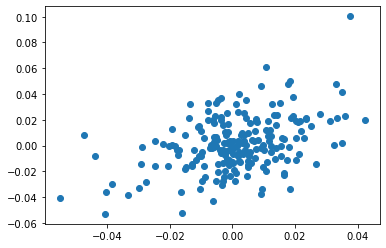

In [74]:
plt.scatter(r_m[20:230].detach().cpu().numpy(),r[20:230,0].detach().cpu().numpy())

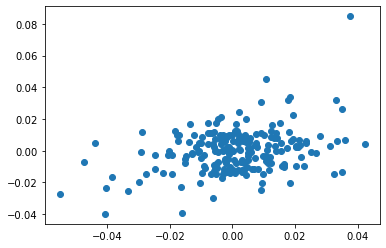

In [157]:
y = r[20:230,0].detach().cpu().numpy().copy()
y[r[20:230,0].detach().cpu().numpy()>0] -= 0.0156
y[r[20:230,0].detach().cpu().numpy()<0] += 0.0132
plt.scatter(r_m[20:230].detach().cpu().numpy(),y)

In [158]:
lr.fit(r_m[20:230].detach().cpu().numpy(),y)
np.std(y - lr.predict(r_m[20:230].detach().cpu().numpy()))

0.012884674

In [125]:
lr.fit(r_m[20:230].detach().cpu().numpy(),r[20:230,0].detach().cpu().numpy())
np.std(r[20:230,0].detach().cpu().numpy() - lr.predict(r_m[20:230].detach().cpu().numpy()))

0.018944947

In [159]:
lr.coef_

array([0.2990492], dtype=float32)

In [133]:
model(r[20:230], r_m[20:230,0:1])

tensor([-0.0848, -0.0903, -0.2789,  ..., -0.2097, -0.1530, -0.1464],
       device='cuda:0', grad_fn=<NegBackward>)

In [150]:
t = time()
model = LOTNet(1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
for i in range(200):
    model.train()
    optimizer.zero_grad()
    loss = loss_func(model(r[20:230,0:1], r_m[20:230]))
    loss.backward()
    optimizer.step()
    if (i + 1) % 20 == 0:
        print('epoch {}'.format(i + 1))
        print('loss: {:.4f}, time used: {:.4f}s'.format(float(loss), time()-t))

epoch 20
loss: -736.3524, time used: 0.1802s
epoch 40
loss: -779.9918, time used: 0.2462s
epoch 60
loss: -798.0799, time used: 0.3103s
epoch 80
loss: -804.5164, time used: 0.3753s
epoch 100
loss: -806.1606, time used: 0.4414s
epoch 120
loss: -806.3729, time used: 0.5065s
epoch 140
loss: -806.3785, time used: 0.5705s
epoch 160
loss: -806.3787, time used: 0.6346s
epoch 180
loss: -806.3791, time used: 0.6996s
epoch 200
loss: -806.3790, time used: 0.7646s


In [161]:
model.sigma

Parameter containing:
tensor([0.0130], device='cuda:0', requires_grad=True)

In [148]:
torch.sum(model.beta > 0)

tensor(1, device='cuda:0')

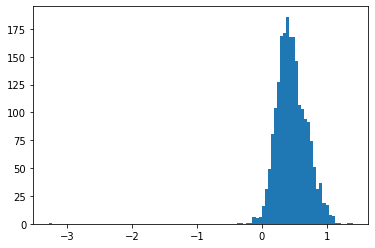

In [78]:
plt.hist(model.beta.detach().cpu().numpy().flatten(),bins=100)
plt.show()

In [152]:
model.alpha_1

Parameter containing:
tensor([[0.0132]], device='cuda:0', requires_grad=True)

In [153]:
model.alpha_2

Parameter containing:
tensor([[-0.0156]], device='cuda:0', requires_grad=True)

In [30]:
from mytools.AutoTester import *
AT = AutoTester

In [71]:
print('cs_rel_sp')
stats = AT.test(signal[21:], se.data.spread_dic['relative_spread'][21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['relative_spread'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


print('ts_rel_sp')
stats = AT.test(signal[21:], se.data.spread_dic['relative_spread'][21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['relative_spread'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_rel_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


print('ts_vol_rel_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

cs_rel_sp
mean corr: -0.0540, positive_corr_ratio: 0.0137, corr_IR: -1.5769
0.0005326726865579947

ts_rel_sp
mean corr: -0.0898, positive_corr_ratio: 0.3590, corr_IR: -0.3837
0.0005326726865579947

cs_vol_rel_sp
mean corr: -0.0465, positive_corr_ratio: 0.0183, corr_IR: -1.5540
0.0005318852959550952

ts_vol_rel_sp
mean corr: -0.0451, positive_corr_ratio: 0.4214, corr_IR: -0.2100
0.0005318852959550952



In [32]:
print('cs_sp')
stats = AT.test(signal[21:], se.data.spread[21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[51:], se.data.spread[21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_sp')
stats = AT.test(signal[21:], se.data.spread[21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread[21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_bas'][21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


print('ts_vol_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_bas'][21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

cs_sp
mean corr: 0.0421, positive_corr_ratio: 0.9863, corr_IR: 1.8660
0.02333245055586285

ts_sp
mean corr: 0.1205, positive_corr_ratio: 0.7227, corr_IR: 0.6040
0.022896406990260066

cs_vol_sp
mean corr: 0.0499, positive_corr_ratio: 0.9954, corr_IR: 1.8653
0.0005320071552560949

ts_vol_sp
mean corr: 0.1411, positive_corr_ratio: 0.7775, corr_IR: 0.7488
0.0005320071552560949



#### Gibbs

In [37]:
# close合法的top
top = np.sum(np.isnan(se.data.data_dic['close']),axis=0)<=15

In [38]:
signal_gibbs = np.zeros((210,np.sum(top)))
for i in range(10):
    c = np.load('../estimator/cache/{}.npy'.format(i))
    signal_gibbs[21*i:21*i+21] = c

In [39]:
print('cs_sp')
stats = AT.test(signal_gibbs, se.data.spread[20:230,top], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal_gibbs, se.data.spread[20:230,top], univ[20:230,top])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_rel_sp')
stats = AT.test(signal_gibbs, se.data.spread_dic['relative_spread'][20:230,top], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal_gibbs, se.data.spread_dic['relative_spread'][20:230,top], univ[20:230,top])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_sp')
stats = AT.test(signal_gibbs, se.data.spread[20:230,top], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal_gibbs, se.data.spread[20:230,top], univ[20:230,top])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_rel_sp')
stats = AT.test(signal_gibbs, se.data.spread_dic['relative_spread'][20:230,top], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal_gibbs, se.data.spread_dic['relative_spread'][20:230,top], univ[20:230,top])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))

cs_sp
mean corr: 0.0024, positive_corr_ratio: 0.5286, corr_IR: 0.1088
0.02302115877274065

cs_rel_sp
mean corr: -0.0006, positive_corr_ratio: 0.4429, corr_IR: -0.0281
0.0005328121884986163

ts_sp
mean corr: -0.0004, positive_corr_ratio: 0.5017, corr_IR: -0.0057
0.02302115877274065

ts_rel_sp
mean corr: 0.0004, positive_corr_ratio: 0.5070, corr_IR: 0.0060
0.0005328121884986163
